In [2]:
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.append('/home1/jrudoler/src/')
import cmlreaders as cml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['savefig.facecolor']='white'
import seaborn as sns
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
from pd_to_pb import pandas_to_pybeh as pb
import scipy as scp
plt.rcParams['axes.labelsize'] = 16
from classifier_io import ClassifierModel
from sklearn.linear_model import LogisticRegression
from sklearn import __version__ as sklearn_version
import pickle
from ptsa.data.filters import MorletWaveletFilter, ButterworthFilter
from ptsa.data.timeseries import TimeSeries
sns.set_palette('twilight')
import cmldask.CMLDask as da
from nicls_helpers import *
import scipy as scp

subject_list = np.loadtxt("final_subject_list.txt", dtype=str)

In [24]:
settings = da.Settings()
settings.rel_start = 300
settings.rel_stop = 1300
settings.buffer_time = 500
settings.freqs = np.logspace(np.log10(6), np.log10(180), 8)
settings.width = 5
settings.experiment = 'NiclsCourierReadOnly'
settings.clean = 1
settings.save = 1
settings.reference = 'average'
# settings.Save("NICLS_CL_encoding_features_cleaned.pkl")

### Cluster Setup

In [2]:
client = da.new_dask_client("nicls_analysis",
                            "100GB",
                           log_directory='/home1/jrudoler/logs/')

Unique port for jrudoler is 51360
{'dashboard_address': ':51360'}
To view the dashboard, run: 
`ssh -fN jrudoler@rhino2.psych.upenn.edu -L 8000:192.168.86.142:51360` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [3]:
client.dashboard_link

'http://192.168.86.144:51360/status'

In [86]:
client.shutdown()

# Classification Performance

## Read-Only

In [32]:
data = cml.get_data_index(kind = 'ltp');
data = data[data['experiment'] == 'NiclsCourierReadOnly']
data = data.query("subject in @subject_list")
full_evs = None
for i, row in data.iterrows():
    if sum(data.subject == row['subject']) < 3:
        continue
    if row['subject']=='LTP480':
        # subject dropped out before closed loop
        continue
    read = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'], montage=0, localization=0)
    evs = read.load('task_events')
#     evs['phase'] = evs['phase'].astype(str)
    evs.drop(index=evs[evs.type.str.contains('VV')].index, inplace=True)
    evs.drop(index=evs.query("phase in ['practice', 'movie', 'video']").index, inplace=True)
    full_evs = evs if full_evs is None else full_evs.append(evs)
# only real delivery days
full_evs = full_evs.reset_index().drop(columns='index')

KeyboardInterrupt: 

In [14]:
sub_recalls = full_evs.query("type=='WORD'").groupby("subject").agg({"recalled":"mean"}).reset_index()

In [15]:
sub_recalls

,subject,recalled
0,LTP448,0.861667
1,LTP449,0.561111
2,LTP451,0.538596
3,LTP453,0.645614
4,LTP455,0.710526
5,LTP457,0.775439
6,LTP458,0.871930
7,LTP462,0.637427
8,LTP468,0.605674
9,LTP470,0.616374


In [16]:
sub_recalls.query("recalled < .8")['subject'].values

array(['LTP449', 'LTP451', 'LTP453', 'LTP455', 'LTP457', 'LTP462',
       'LTP468', 'LTP470', 'LTP474', 'LTP476', 'LTP477', 'LTP481',
       'LTP488', 'LTP491', 'LTP493', 'LTP494', 'LTP495', 'LTP497',
       'LTP498', 'LTP500'], dtype=object)

### LOSO Cross-validation with session-level zscore across all events

In [2]:
from nicls_helpers import train_read_only_class

In [46]:
#subject_list = full_evs.subject.unique() #np.array(['LTP462','LTP468', 'LTP470', 'LTP474', 'LTP476', 'LTP477', 'LTP481', 'LTP488'])
subject_list = subject_list[(subject_list > 'LTP460')] # &(subject_list < 'LTP490')
c_list = np.logspace(np.log10(2e-5), np.log10(1), 9)
path = '/scratch/nicls_intermediate/read_only/bipolar_encoding_powers/'

result_dict = {}

futures = client.map(train_read_only_class, subject_list, c_list=c_list, path = path)
from dask.distributed import progress
progress(futures)

VBox()

In [47]:
da.get_exceptions(futures, subject_list)

NameError: name 'Exceptions' is not defined

In [48]:
good_futures = da.filter_futures(futures)
success_mask = np.isin(futures, good_futures)
results = client.gather(good_futures)
for i, subject in enumerate(subject_list[success_mask]):
    result_dict[subject] = results[i]
    
with open(f"loso_results_bipolar_read_only.pkl", "wb") as f:
    pickle.dump(result_dict, f)

In [50]:
with open(f"loso_results_clean_read_only.pkl", "rb") as f:
    clean_result_dict = pickle.load(f)

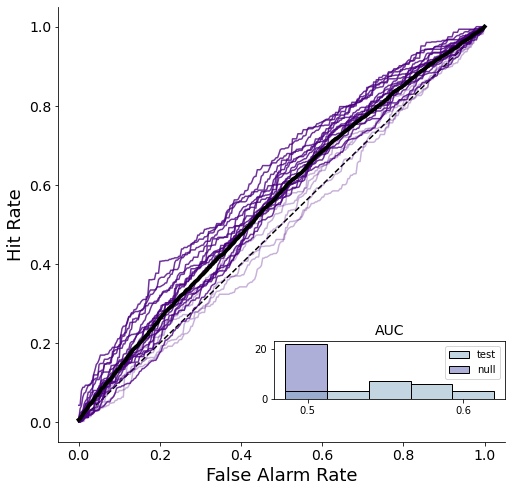

In [13]:
with open(f"loso_results_read_only.pkl", "rb") as f:
    result_dict = pickle.load(f)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
for subject in cl_result_dict:
    fp, tp, auc, _ = result_dict[subject]
    tp = scp.interp(base_fp, fp, tp)
    tp_list.append(tp)
    if np.mean(result_dict[subject][2] > result_dict[subject][3])>=0.95:
        alpha=0.8
    else:
        alpha=0.3
    ax.plot(base_fp, tp, color='indigo', label=f"{subject}, AUC = {auc:.3f}", alpha=alpha)

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4,
        label=f"{subject}, AUC = {auc:.3f}", alpha=1)

# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18)
ax.set_xlabel('False Alarm Rate', fontsize=18)
ax.grid(False)
ax_pos = np.array(ax.get_position()).ravel()
top_ax = fig.add_axes([0.5, .2, .4, .1])
auc_dist = pd.DataFrame({"auc":[result_dict[k][2] for k in result_dict] +
                         [np.mean(result_dict[k][3]) for k in result_dict],
                         "type":["test"]*len(result_dict)+["null"]*len(result_dict)})
sns.histplot(auc_dist, x="auc", hue="type", multiple="layer", bins=5, ax=top_ax)
sns.move_legend(top_ax, loc='upper right', title='')
top_ax.grid(False)
top_ax.set_title('AUC', fontsize=14)
top_ax.set_xticks([.5, .6])
top_ax.set_xlabel('')
top_ax.set_ylabel('')
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# top_ax.tick_params(labelsize=14)
np.mean([result_dict[k][2] for k in result_dict])
# plt.savefig('FinalReport/loso_read_only.pdf', dpi=200, bbox_inches='tight')

In [5]:
np.array([np.mean(result_dict[k][2] > result_dict[k][3])>=0.95 for k in result_dict])

array([ True, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True])

In [114]:
t, p = scp.stats.ttest_rel(
np.array([result_dict[k][2] for k in cl_result_dict]),
np.array([np.mean(result_dict[k][3]) for k in cl_result_dict])
)
mean = np.array([result_dict[k][2] for k in cl_result_dict]).mean()
sem = scp.stats.sem(np.array([result_dict[k][2] for k in cl_result_dict]), ddof=1)
print(t, p, mean, sem)

6.757080906380654 1.4256390018797065e-06 0.5566160878534587 0.008282556497288313


In [115]:
t, p = scp.stats.ttest_rel(
np.array([cl_result_dict[k][2] for k in cl_result_dict]),
np.array([np.mean(cl_result_dict[k][3]) for k in cl_result_dict])
)
mean = np.array([cl_result_dict[k][2] for k in cl_result_dict]).mean()
sem = scp.stats.sem(np.array([cl_result_dict[k][2] for k in cl_result_dict]), ddof=1)
print(t, p, mean, sem)

2.145548144232949 0.044366391989229044 0.5440762737672168 0.020485695383793613


In [64]:
res = pd.DataFrame({"subject":result_dict.keys(),
                    "AUC":[result_dict[k][2] for k in result_dict],
                    "clean_AUC":[clean_result_dict[k][2] for k in result_dict],
                    "bipolar_AUC":[bipolar_result_dict[k][2] for k in result_dict]
                   })

In [66]:
res.to_csv("read_only_AUC_comparisons.csv")

<AxesSubplot:xlabel='value', ylabel='Count'>

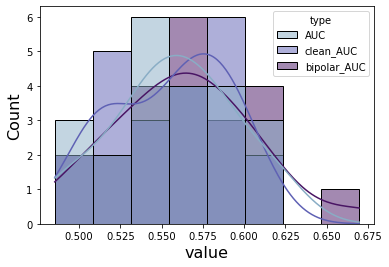

In [81]:
sns.histplot(pd.melt(res, value_vars=['AUC', 'clean_AUC', 'bipolar_AUC'], var_name='type'), x='value', hue='type', kde=True)

In [18]:
res = pd.read_csv("read_only_AUC_comparisons.csv", index_col=0)

In [22]:
res = res[res.subject!="LTP499"]

In [31]:
with open("AUC_comparison.tex", "w") as f:
    f.write(res.to_latex(float_format="%.3f", longtable=True, 
                       label="AUC_comparison",
                       caption="\\textbf{Preprocessing Methods and Classifier Performance} "+ \
                       "We found no significant difference in classifier performance (AUC) between "+ \
                       "different pre-processing methods. Our default pre-processing was to just use a global "+ \
                       "average reference scheme coupled with a lowpass filter for drift and a bandpass filter "+ \
                       "to remove electrical line noise. We compared this approach to pre-processing with ICA-based "+ \
                       "localized component filtering ($t$(21)=0.193, $p$=0.85) "+ \
                       "and also to a bipolar reference scheme ($t$(21)=0.316, $p$=0.75)."))

In [23]:
scp.stats.ttest_rel(res["AUC"], res["clean_AUC"])

Ttest_relResult(statistic=0.19303756833282604, pvalue=0.8488763833468397)

In [24]:
scp.stats.ttest_rel(res["AUC"], res["bipolar_AUC"])

Ttest_relResult(statistic=-0.31642110379348315, pvalue=0.7549617093030289)

In [25]:
scp.stats.ttest_1samp([result_dict[k][2] for k in cl_result_dict], 0.5)

Ttest_1sampResult(statistic=6.835581244992977, pvalue=1.2096635104608003e-06)

In [26]:
scp.stats.ttest_1samp([cl_result_dict[k][2] for k in cl_result_dict], 0.5)

Ttest_1sampResult(statistic=2.1515634661875263, pvalue=0.04383090164736231)

### Checking Read-Only Classifier With Varying Normalization Lists

In [19]:
# subject_list = full_evs['subject'].unique()
c_list = np.logspace(np.log10(2e-5), np.log10(1), 9)
# path = '/scratch/nicls_intermediate/read_only/encoding_powers/'
def n_list_normalization(n_lists, subject_list, c_list = np.logspace(np.log10(2e-5), np.log10(1), 9), path='/scratch/nicls_intermediate/read_only/encoding_powers/'):
    result_dict = {}
    for subject in subject_list:
        ts = TimeSeries.from_hdf(path+subject+"_feats.h5", engine="netcdf4")
        evs = ts.indexes['event'].to_frame(index=False)
        ts = ts.groupby('session').apply(norm_sess_feats, n_lists=n_lists)
        scores_mat = computeCV(ts.data, evs, c_list)
        best_c = c_list[scores_mat.mean(0).argmax()]
        model = LogisticRegression(penalty='l2', C=best_c, class_weight='balanced', solver='liblinear')
        prob = perform_normed_loso_cross_validation(model, events=evs, powers=ts, n_lists=n_lists)
        fp, tp, _ = roc_curve(evs.recalled.values, prob)
        auc = roc_auc_score(evs.recalled.values, prob)
        result_dict[subject] = (fp, tp, auc)

    with open(f"{n_lists}_list_normalization.pkl", "wb") as f:
        pickle.dump(result_dict, f)

futures = []
for n_lists in range(1, 11):
    futures.append(client.submit(n_list_normalization, n_lists, [s for s in cl_result_dict]))

In [16]:
client.cancel(futures)

In [10]:
len([s for s in cl_result_dict])

21

In [20]:
from dask.distributed import progress
progress(futures)

VBox()

In [24]:
da.get_exceptions(futures, np.arange(1, 11))

Exception: None of the given futures resulted in exceptions

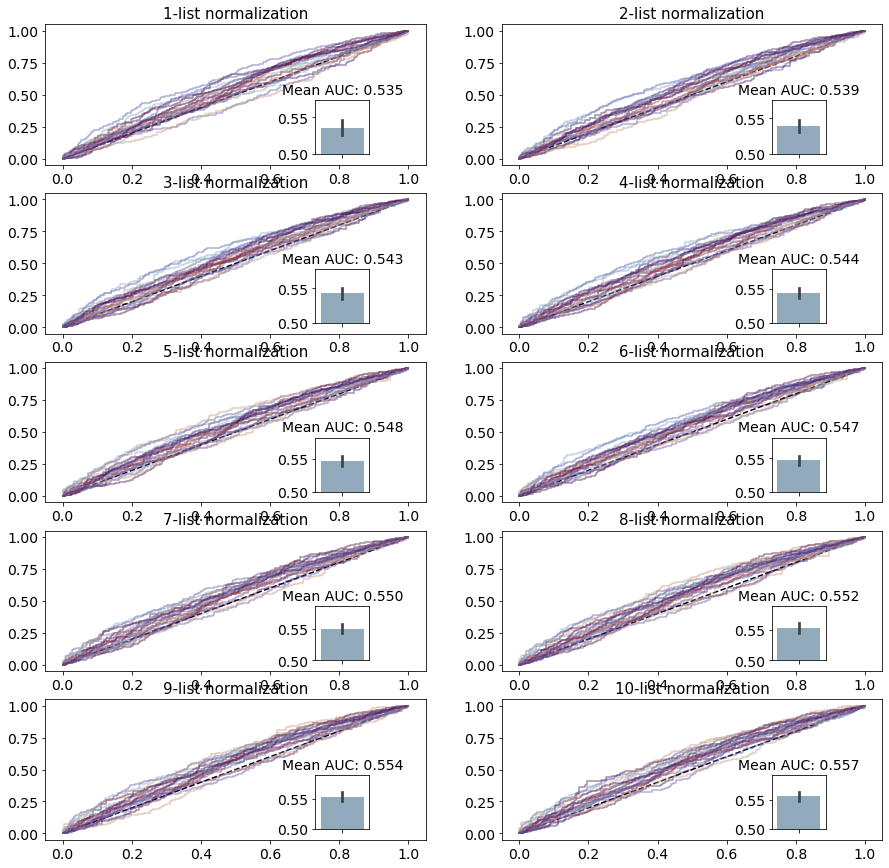

In [25]:
sns.set_palette('twilight')
plt.rcParams['figure.facecolor']='white'
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
ax = ax.ravel()
res_frame = []
for i, n_lists in enumerate(range(1, 11)):
    with open(f"{n_lists}_list_normalization.pkl", "rb") as f:
        result_dict = pickle.load(f)
    result_dict = {k:result_dict[k] for k in cl_result_dict if int(k[-3:])>460}
    res_frame.append(pd.DataFrame({'subject':[s for s in cl_result_dict], 'auc': [result_dict[k][2] for k in cl_result_dict], 'nlists':n_lists}))
    ax[i].plot([0, 1], [0, 1], '--k')
    for subject in result_dict:
        fp, tp, auc = result_dict[subject]
        ax[i].plot(fp, tp, label=f"{subject}, AUC = {auc:.3f}", alpha=0.5)
    # ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
#     ax[i].set_xlabel('FPR', fontsize=18)
#     ax[i].set_ylabel('TPR', fontsize=18)
    ax[i].grid(False)
    ax_pos = np.array(ax[i].get_position()).ravel()
    top_ax = fig.add_axes(np.array([ax_pos[0]+.25, ax_pos[1]+.01, .05, .05]))
    sns.barplot(y=[result_dict[k][2] for k in result_dict], orient='vertical', ci=68, ax=top_ax)
    mean = np.mean([result_dict[k][2] for k in result_dict])
    top_ax.set_ylim(0.5)
    top_ax.grid(False)
    top_ax.set_title(f'Mean AUC: {mean:.3f}', fontsize=14)
    ax[i].tick_params(labelsize=14)
    top_ax.tick_params(labelsize=14)
    ax[i].set_title(f'{n_lists}-list normalization', fontsize=15)
    
# plt.tight_layout()
res_frame = pd.concat(res_frame)
plt.savefig('FinalReport/readonly_loso_varying_norm.pdf', dpi=200, bbox_inches='tight')

In [32]:
res_frame

,subject,auc,nlists,auc_less_mean
0,LTP462,0.515774,1,-0.016774
1,LTP468,0.456944,1,-0.014708
2,LTP470,0.577232,1,-0.013388
3,LTP473,0.506079,1,-0.018135
4,LTP474,0.554209,1,-0.019141
...,...,...,...,...
16,LTP495,0.536795,10,-0.000862
17,LTP496,0.492316,10,-0.001693
18,LTP497,0.549361,10,0.000366
19,LTP498,0.523560,10,-0.001825


In [33]:
sns.pointplot?

Signature:
sns.pointplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    estimator=<function mean at 0x2ae732a59700>,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    markers='o',
    linestyles='-',
    dodge=False,
    join=True,
    scale=1,
    orient=None,
    color=None,
    palette=None,
    errwidth=None,
    capsize=None,
    ax=None,
    **kwargs,
)
Docstring:
Show point estimates and confidence intervals using scatter plot glyphs.

A point plot represents an estimate of central tendency for a numeric
variable by the position of scatter plot points and provides some
indication of the uncertainty around that estimate using error bars.

Point plots can be more useful than bar plots for focusing comparisons
between different levels of one or more categorical variables. They are
particularly adept at showing interactions: how the relationship between
levels of one categorical variable changes across levels of a se

(0.5, 0.5593870939785306)

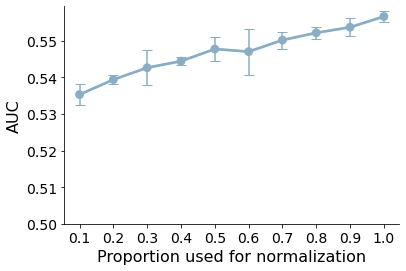

In [45]:
res_frame['auc_less_mean'] = res_frame.groupby('subject')["auc"].apply(lambda series: series - series.mean()).values
ax = sns.pointplot(data=res_frame, x='nlists', y='auc', ci=None)
err = res_frame.groupby('nlists').agg({'auc':'mean', 'auc_less_mean':'sem'})
plt.errorbar(range(0, 10), y=err['auc'], yerr=err['auc_less_mean'], capsize=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([i/10 for i in range(1, 11)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel('Proportion used for normalization', fontsize=16)
ax.set_ylabel('AUC', fontsize=16)
plt.grid(False)
plt.ylim(0.5, None)
# plt.savefig('FinalReport/AUC_by_pnorm.pdf', dpi=200, bbox_inches='tight')

In [27]:
p_list = []
for subject, df in res_frame.groupby('subject'):
    p_list.append(np.polyfit(x=df['nlists'], y=df['auc'], deg=1))
p_list=np.stack(p_list)

In [28]:
scp.stats.ttest_1samp(p_list[:, 0], popmean=0)

Ttest_1sampResult(statistic=3.18637608414388, pvalue=0.004638157101947827)

# CL Behavioral Data

In [11]:
cl_data = cml.get_data_index(kind = 'ltp');
cl_data = cl_data[cl_data['experiment'] == 'NiclsCourierClosedLoop']

In [ ]:
cl_data.groupby("subject").count()

,all_events,experiment,import_type,math_events,original_session,session,subject_alias,task_events
subject,,,,,,,,
LTP448,4,4,4,0,4,4,4,4
LTP449,4,4,4,0,4,4,4,4
LTP451,4,4,4,0,4,4,4,4
LTP453,4,4,4,0,4,4,4,4
LTP455,4,4,4,0,4,4,4,4
LTP457,4,4,4,0,4,4,4,4
LTP458,4,4,4,0,4,4,4,4
LTP462,2,2,2,0,2,2,2,2
LTP468,2,2,2,0,2,2,2,2


In [ ]:
cl_data = cml.get_data_index(kind = 'ltp');
cl_data = cl_data[cl_data['experiment'] == 'NiclsCourierClosedLoop']

# Subjects with good classification protocol and low recall
cl_data = cl_data.query("subject in @subject_list")
performance_stats = pd.read_csv("system_performance_stats_FR_only.csv", header=[0, 1], index_col=[0, 1])

cl_data = cl_data[~performance_stats['bad_session'].values.ravel()]

CL_evs = None
for i, row in cl_data.iterrows():
    if sum(cl_data.subject == row['subject']) < 1: 
        continue
    read = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'], montage=0, localization=0)
    evs = read.load('task_events')
#     evs['phase'] = evs['phase'].astype(str)
    evs.drop(index=evs[evs.type.str.contains('VV')].index, inplace=True)
    evs.drop(index=evs.query("phase in ['practice', 'movie', 'video']").index, inplace=True)
    
    CL_evs = evs if CL_evs is None else CL_evs.append(evs)
# only real delivery days
CL_evs = CL_evs.reset_index().drop(columns='index')

res = CL_evs.groupby(['subject','session', 'trial']).agg({'classifier':lambda x: list(np.unique([i for i in x if i!='X'])) or 'NoStim'})
res = res.apply(lambda x: [i if isinstance(i, str) else i[0] for i in x])

CL_evs['trial_type']=''
for (subject, session, trial), row in res.iterrows():
    idx = CL_evs.query(f"subject=='{subject}' & session=={session} & trial=={trial}").index
    CL_evs['trial_type'][idx] = [row['classifier']]*len(idx)

final = CL_evs.query('type=="WORD"')

# subject_list = final.subject.unique()

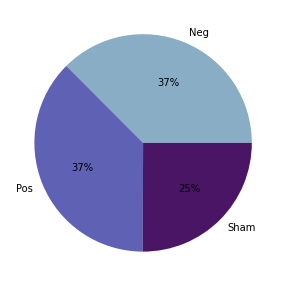

In [7]:
class_evs = CL_evs[(CL_evs.type=='TIMEOUT')|(CL_evs.type=='CLASSIFIER')]
# Show we have expected proportions
types = class_evs.groupby('classifier').count()['item']
plt.figure(figsize=(5, 5))
_ = plt.pie(types, labels=types.index.values, autopct='%1.0f%%')

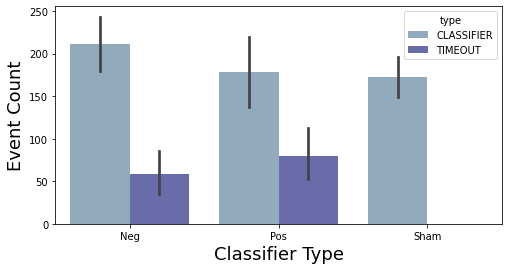

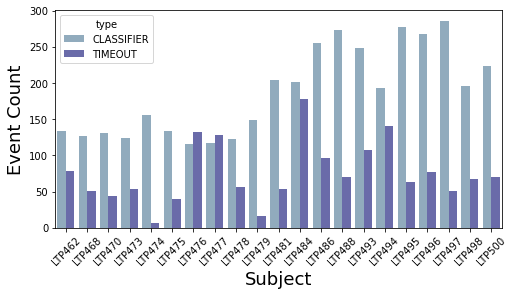

In [62]:
# See how many items timed out vs. had action changed by classifier result
props = class_evs.groupby(['subject','classifier', 'type']).agg({'item':'count'})

plt.figure(figsize=(8, 4))
sns.barplot(data = props.reset_index(), x='classifier', y='item', hue='type')
plt.xlabel('Classifier Type', fontsize=18)
plt.ylabel('Event Count', fontsize=18)
# plt.savefig()

plt.figure(figsize=(8, 4))
sns.barplot(data = props.reset_index(), x='subject', y='item', hue='type', ci=None)
plt.xlabel('Subject', fontsize=18)
plt.ylabel('Event Count', fontsize=18)
_ = plt.xticks(rotation=45)

### Correlating Recall and AUC

In [10]:
avg = final.groupby(
    ['subject', 'session']
).agg(
    {'recalled':'mean'}
).mean(level=0)

above_med = avg >= avg.median()

final['above_avg'] = np.isin(final['subject'].values, above_med.index[above_med['recalled']])

In [57]:
avg = avg.reset_index()
avg['RO_auc'] = avg['subject'].apply(lambda k: result_dict[k][2])
avg['CL_auc'] = avg['subject'].apply(lambda k: cl_result_dict[k][2])
avg.set_index('subject')

,recalled,RO_auc,CL_auc
subject,,,
LTP462,0.546667,0.550459,0.656436
LTP468,0.600000,0.485519,0.483852
LTP470,0.586667,0.575867,0.601562
LTP473,0.893333,0.522095,0.471555
LTP474,0.746667,0.541850,0.586807
LTP475,0.930000,0.589504,0.391741
LTP476,0.613333,0.585922,0.663475
LTP477,0.603333,0.619852,0.636016
LTP478,0.803333,0.508076,0.546335


<AxesSubplot:xlabel='recalled', ylabel='CL_auc'>

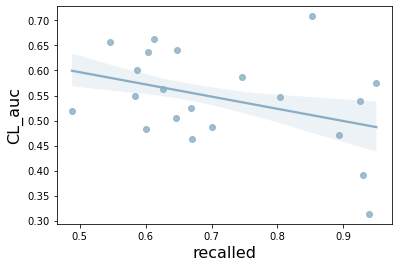

In [65]:
sns.regplot(data=avg, x="recalled", y="CL_auc", ci=68)

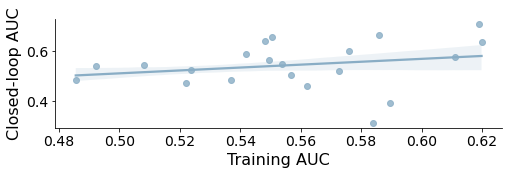

In [66]:
plt.figure(figsize=(8, 2))
ax = sns.regplot(data=avg, x="RO_auc", y="CL_auc", ci=68)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=14)
ax.set_xlabel("Training AUC")
ax.set_ylabel("Closed-loop AUC")
plt.savefig('FinalReport/auc_train_test_correlation.png', dpi=300, bbox_inches='tight')

## Evaluating memory improvement

In [9]:
plot_data

recalled  session
subject trial_type                   
LTP462  Neg         0.477778        2
        Pos         0.577778        2
        Sham        0.400000        2
LTP468  Neg         0.544444        2
        Pos         0.622222        2
...                      ...      ...
LTP498  Pos         0.622222        3
        Sham        0.711111        3
LTP500  Neg         0.655556        4
        Pos         0.633333        4
        Sham        0.533333        4

[63 rows x 2 columns]

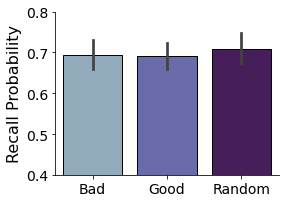

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.rcParams['figure.facecolor']='white'
sns.set_palette('twilight')
plot_data = final.query("trial_type!='NoStim'").groupby(['subject', 'trial_type', 'session']).agg('mean').reset_index()\
            .groupby(['subject', 'trial_type']).agg({"recalled":'mean', "session":"count"})
sns.barplot(data=plot_data.reset_index(),
            x = 'trial_type',
            y='recalled',
            ec='k',
            ci=68,
            ax=ax
)
plt.xlabel('', fontsize=18)
plt.ylabel('Recall Probability')
ax.set_xticklabels(["Bad", "Good", "Random"])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0.4, .8)
plt.grid(False)
# plt.savefig('FinalReport/stim_effect.pdf', dpi=200, bbox_inches='tight')

In [62]:
avg["positive"] = plot_data.xs('Pos', level=1)['recalled'].values
avg["negative"] = plot_data.xs('Neg', level=1)['recalled'].values
avg["sham"] = plot_data.xs('Sham', level=1)['recalled'].values
avg["pct_change"] = 100*(plot_data.xs('Pos', level=1)['recalled'] - plot_data.xs('Neg', level=1)['recalled']).values / plot_data.xs('Neg', level=1)['recalled'].values

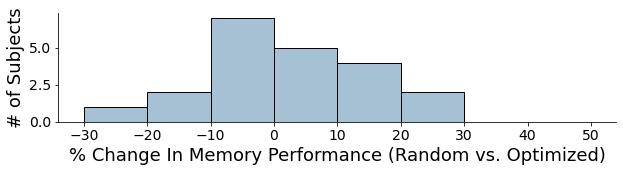

In [63]:
plt.figure(figsize=(10, 2))
ax = sns.histplot(avg, x="pct_change", bins=range(-30, 51, 10))
ax.set_xlabel("% Change In Memory Performance (Random vs. Optimized)", fontsize=18)
ax.set_ylabel("# of Subjects", fontsize=18)
# ax.set_yticks([1, 2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=14)
plt.savefig('FinalReport/pct_change_memory.pdf', dpi=200, bbox_inches='tight')

In [64]:
df = final.groupby(["subject", "trial_type", "recalled"]).agg({"item":"count"}).reset_index()
df = df.pivot(index=["subject", "trial_type"], columns="recalled", values="item")
df.fillna(0, inplace=True)

p_dict = {}
for idx, frame in df.reset_index().groupby("subject"):
    frame = frame.query("trial_type in ['Pos', 'Neg']")
#     chi2, p, _, _= scp.stats.chi2_contingency(frame[[0, 1]].values)
    chi2, p = scp.stats.fisher_exact(frame[[1, 0]].values)
#     print(frame[[1, 0]].values)
#     print(chi2, p)
    p_dict[idx] = p

avg['p'] = avg['subject'].map(p_dict)
avg['sig'] = avg['p'] <= .05

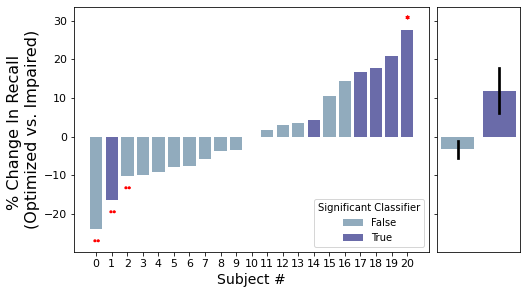

In [67]:
avg_sorted = avg.sort_values("pct_change").reset_index()
fig = plt.figure(figsize=(8, 4.5))
gs = fig.add_gridspec(1, 10)
ax = fig.add_subplot(gs[0:8])
sns.barplot(data=avg_sorted, ax=ax,
            x="subject", y="pct_change", hue="good_class", dodge=False)
plt.xticks(ticks=np.arange(len(avg_sorted)), labels=np.arange(len(avg_sorted)))
sns.move_legend(ax, 0, title="Significant Classifier")
avg_ax = fig.add_subplot(gs[8:10])
avg_ax.sharey(ax)
sns.barplot(data=avg_sorted, ax = avg_ax, x="good_class", y="pct_change", hue="good_class", errcolor='black', ci=68, dodge=False)
avg_ax.legend_.remove()
avg_ax.set_xticks([])
avg_ax.set_xlabel("")
ax.tick_params(labelsize=11)
avg_ax.tick_params(labelleft=False, labelsize=12, labelrotation=60)
avg_ax.set_ylabel("")
ax.set_xlabel("Subject #", fontsize=14)
ax.set_ylabel("% Change In Recall \n(Optimized vs. Impaired)")
mask05 = avg_sorted['p'] <= 0.05
mask1 = (avg_sorted['p'] <= 0.1)&(avg_sorted['p'] > 0.05)
ax.scatter(np.arange(len(avg))[mask05], avg_sorted["pct_change"][mask05]+np.sign(avg_sorted["pct_change"])[mask05]*3, marker='$**$', c='r', s=30)
ax.scatter(np.arange(len(avg))[mask1], avg_sorted["pct_change"][mask1]+np.sign(avg_sorted["pct_change"])[mask1]*3, marker='$*$', c='r', s=30)
# plt.savefig("FinalReport/sorted_pct_change.pdf", dpi=300, bbox_inches="tight")

In [68]:
scp.stats.ttest_1samp(avg.query("good_class")["pct_change"], 0)

Ttest_1sampResult(statistic=1.8336557273067577, pvalue=0.12617294117100103)

In [69]:
scp.stats.ttest_1samp(avg.query("~good_class")["pct_change"], 0)

Ttest_1sampResult(statistic=-1.33684105908533, pvalue=0.20259335569609468)

In [72]:
scp.stats.ttest_ind(avg.query("good_class")["pct_change"], avg.query("~good_class")["pct_change"])

Ttest_indResult(statistic=2.73231671459519, pvalue=0.013232250607167324)

In [80]:
scp.stats.pearsonr(avg["CL_auc"], avg["pct_change"])

(0.37426300274990937, 0.09463227218196262)

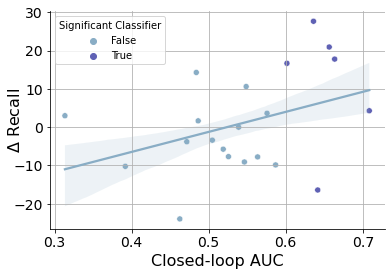

In [34]:
plt.rcParams['savefig.facecolor']='none'
plt.figure(figsize=(6, 4))
ax = sns.scatterplot(data=avg, x="CL_auc", y="pct_change", ci=68, hue="good_class")
sns.regplot(data=avg, x="CL_auc", y="pct_change", ci=68, scatter=False, ax=ax)
sns.move_legend(ax, 0, title="Significant Classifier")
# ax.legend_.remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=14)
ax.set_xlabel("Closed-loop AUC")
ax.set_ylabel("$\Delta$ Recall", labelpad=-10)
plt.grid(True)
r, p = scp.stats.pearsonr(avg["CL_auc"], avg["pct_change"])
ax.annotate(f"Pearson R: {r}\n p:{p}", xy=(.1, .1))
plt.savefig('FinalReport/auc_test_pct_change_correlation.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='trial', ylabel='recalled'>

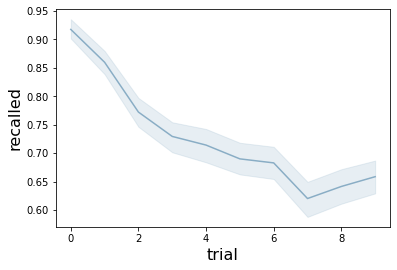

In [79]:
sns.lineplot(data=final, x = 'trial', y='recalled', ci=95)

## Closed-Loop Classifier Performance

In [3]:
from compute_scalp_features import compute_scalp_features

In [4]:
ro_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/NICLS/NICLS_RO_encoding_features.pkl",
                        save_path = '/scratch/nicls_intermediate/read_only/encoding_powers/')

In [5]:
ro_futures

[<Future: pending, key: compute_scalp_features-f6802bada31e1cd624adda28a0bce2b0>,
 <Future: pending, key: compute_scalp_features-ed1e78f9e90d90404eeecf5cf5b2676d>,
 <Future: pending, key: compute_scalp_features-e53559513f56f577a955fe7c2f92c7ff>,
 <Future: pending, key: compute_scalp_features-152ad1c2e1b2fb2c0e73b6e852f51f1b>,
 <Future: pending, key: compute_scalp_features-55adbcd600f8796976cabb735ebc0fa8>,
 <Future: pending, key: compute_scalp_features-39a78b493de1b6b44bd52d90565a1a57>,
 <Future: pending, key: compute_scalp_features-17e743540b095edb2247a982239f4b5d>,
 <Future: pending, key: compute_scalp_features-a745e55d28222cb1cdf25961f62b5332>,
 <Future: pending, key: compute_scalp_features-229df7e74d53468405a9c85a3b583e82>,
 <Future: pending, key: compute_scalp_features-38bb26bc2d6a9e6d75420753d12588c3>,
 <Future: pending, key: compute_scalp_features-9fc746dfbbb9a2e3ac981e168d4d6a08>,
 <Future: pending, key: compute_scalp_features-afcdc1bfeafb4d8a866d1ceb424e8b8c>,
 <Future: pendin

In [124]:
client.shutdown()

In [ ]:
da.Settings.Load("/home1/jrudoler/NICLS/NICLS_RO_encoding_features.pkl")

Settings(rel_start=300, rel_stop=1300, buffer_time=500, freqs=array([  6.        ,   9.75368156,  15.85571732,  25.77526961,
        41.90062864,  68.11423148, 110.72742057, 180.        ]), width=5, experiment='NiclsCourierReadOnly', clean=0, save=1, reference='average')

In [98]:
r = cml.CMLReader("LTP462","NiclsCourierReadOnly", 0)

In [101]:
evs = r.load("events")
word_evs = evs[(evs.type=='WORD')&(evs.eegoffset!=-1)]
r.load_eeg(word_evs, 0, 100)

Extracting EDF parameters from /protocols/ltp/subjects/LTP462/experiments/NiclsCourierReadOnly/sessions/0/ephys/current_processed/LTP462_session_0.bdf...
BDF file detected


FileNotFoundError: [Errno 2] No such file or directory: '/protocols/ltp/subjects/LTP462/experiments/NiclsCourierReadOnly/sessions/0/ephys/current_processed/LTP462_session_0.bdf'

In [92]:
da.print_traceback(da.get_exceptions(ro_futures, subject_list), 'LTP462')

  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/dask/utils.py", line 41, in apply
    return func(*args, **kwargs)
  File "/home1/jrudoler/NICLS/compute_scalp_features.py", line 36, in compute_scalp_features
    eeg = r.load_eeg(word_evs,
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/cmlreaders/cmlreader.py", line 315, in load_eeg
    return self.load('eeg', **kwargs)
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/cmlreaders/cmlreader.py", line 225, in load
    return cls.load(**kwargs)
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/cmlreaders/readers/eeg.py", line 601, in load
    return self.as_timeseries(events, kwargs["rel_start"],
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/cmlreaders/readers/eeg.py", line 708, in as_timeseries
    data, info = reader.read()
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/cmlreaders/readers/eeg.py"

In [6]:
bipolar_ro_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/NICLS/NICLS_RO_encoding_features_bipolar.pkl",
                        save_path = '/scratch/nicls_intermediate/read_only/bipolar_encoding_powers/')

In [36]:
cl_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/NICLS/NICLS_CL_encoding_features_cleaned.pkl",
                        save_path = '/scratch/nicls_intermediate/closed_loop/clean_encoding_powers/')

In [8]:
bipolar_cl_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/NICLS/NICLS_CL_encoding_features_bipolar.pkl",
                        save_path = '/scratch/nicls_intermediate/closed_loop/bipolar_encoding_powers/')

Do this by averaging ROC / AUC within session?

### One-list normalization for closed loop

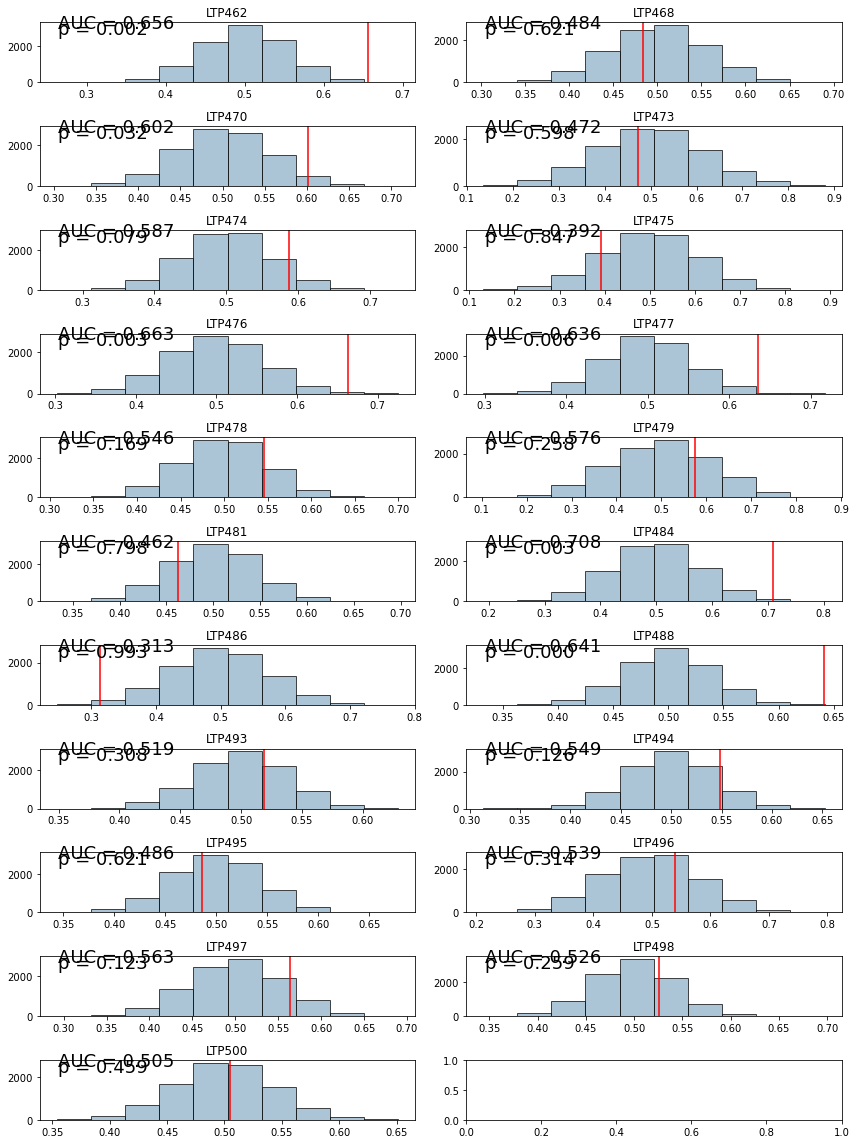

In [20]:
path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/'

# with open("all_nicls_subjects.txt", "r") as f:
#     cl_sub_list = f.read().splitlines()
cl_sub_list = CL_evs['subject'].unique()
cl_sub_list = [s for s in cl_sub_list if int(s[-3:])>460]
fig, ax = plt.subplots(len(cl_sub_list) // 2 + len(cl_sub_list) % 2, 2, figsize=(12, 16))
ax = ax.ravel()
cl_result_dict = {}
for i, subject in enumerate(cl_sub_list):
#     try:
    if subject == 'LTP499':
        continue
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
#     except:
#         continue
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').apply(norm_sess_feats, n_lists=1)
    
    model = ClassifierModel(
        LogisticRegression(),
        sklearn_version=sklearn_version
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model

    sham_powers = ts.isel(event=evs.query('trial_type in ["Sham", "NoStim"]').index).data
    prob = model.predict_proba(sham_powers)[:, 1]
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    fp, tp, _ = roc_curve(evs.recalled.values, prob)
    auc = roc_auc_score(evs.recalled.values, prob)
    auc_results = [roc_auc_score(np.random.choice(evs.recalled.values,
                                                  size=len(evs),
                                                 replace=False),
                                 prob)
                   for i in range(10000)]
    cl_result_dict[subject] = (fp, tp, auc, auc_results)
    p_val = (sum(auc_results>auc)+1) / (len(auc_results)+1)
    ax[i].set_title(subject)
    ax[i].hist(auc_results, ec='k', alpha=.7)
    ax[i].axvline(auc, c='r')
#     ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=18)
    ax[i].annotate(f'p = {p_val:.3f}', xy=(.05, .8), xycoords='axes fraction', fontsize=18)
    ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=18)
plt.tight_layout()

In [ ]:
with open(f"clf_results_closed_loop.pkl", "wb") as f:
    pickle.dump(cl_result_dict, f)

In [3]:
from scipy.stats import zscore

#### Full session normalization

In [ ]:
path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/'
# with open("all_nicls_subjects.txt", "r") as f:
#     cl_sub_list = f.read().splitlines()
cl_sub_list = CL_evs['subject'].unique()
cl_sub_list = [s for s in cl_sub_list if int(s[-3:])>460]
cl_result_dict = {}
for i, subject in enumerate(cl_sub_list):
    try:
        if subject == 'LTP499':
            continue
        ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    except:
        continue
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').reduce(zscore, ddof=1)
    
    model = ClassifierModel(
        LogisticRegression(),
        sklearn_version=sklearn_version
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model

    sham_powers = ts.isel(event=evs.query('trial_type in ["Sham", "NoStim"]').index).data
    prob = model.predict_proba(sham_powers)[:, 1]
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    fp, tp, _ = roc_curve(evs.recalled.values, prob)
    auc = roc_auc_score(evs.recalled.values, prob)
    auc_results = [roc_auc_score(np.random.choice(evs.recalled.values,
                                                  size=len(evs),
                                                 replace=False),
                                 prob)
                   for i in range(10000)]
    cl_result_dict[subject] = (fp, tp, auc, auc_results)

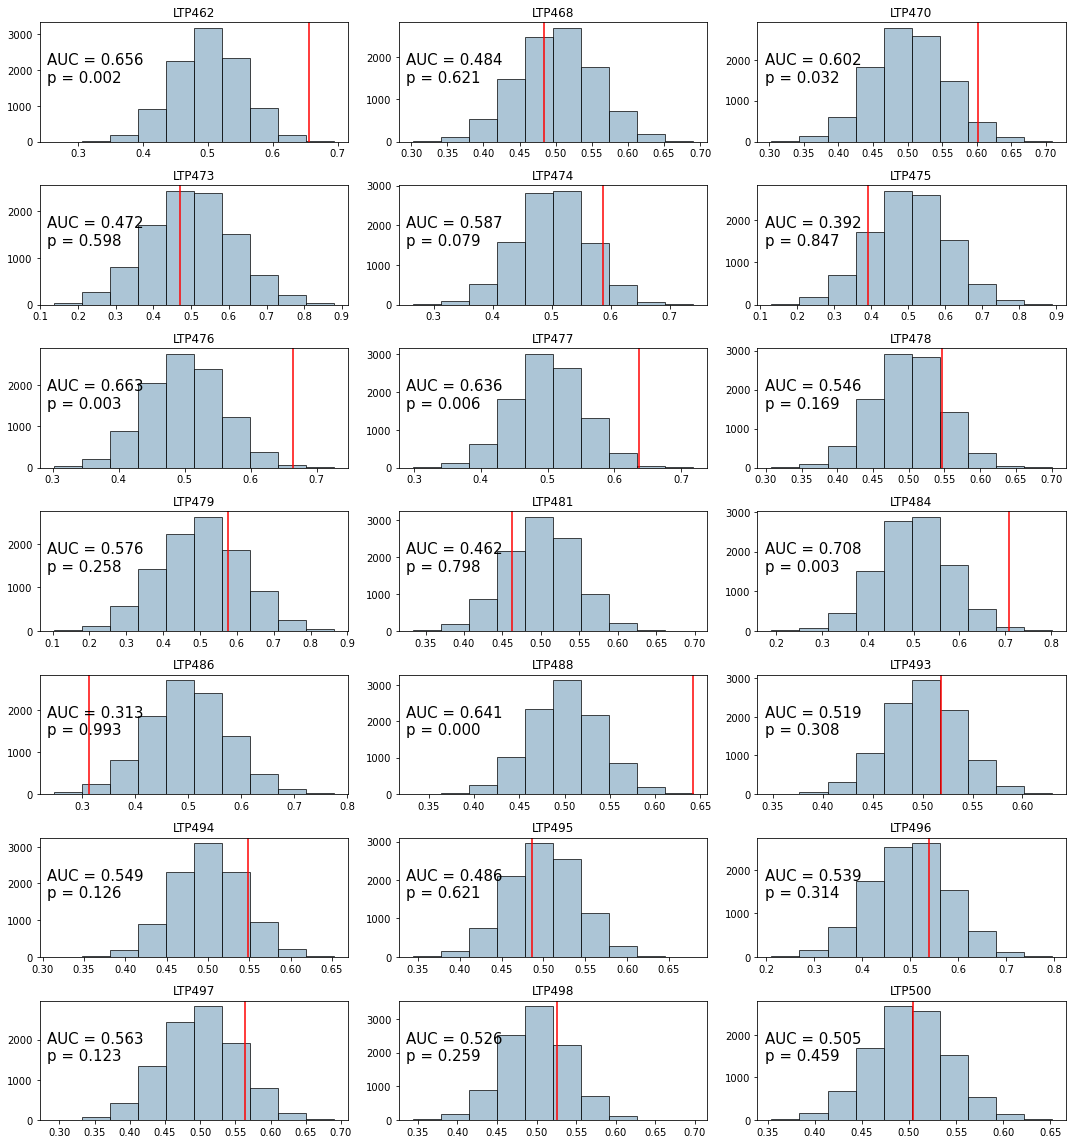

In [33]:
with open(f"clf_results_closed_loop.pkl", "rb") as f:
    cl_result_dict = pickle.load(f)
fig, ax = plt.subplots(len(cl_sub_list) // 3 + len(cl_sub_list) % 3, 3, figsize=(15, 16))
ax = ax.ravel()
for i, subject in enumerate(cl_result_dict):
    (fp, tp, auc, auc_results) = cl_result_dict[subject]
    p_val = (sum(auc_results>auc)+1) / (len(auc_results)+1)
    ax[i].set_title(subject)
    ax[i].hist(auc_results, ec='k', alpha=.7)
    ax[i].axvline(auc, c='r')
#     ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=18)
#     ax[i].annotate(f'p = {p_val:.3f}', xy=(.025, .6), xycoords='axes fraction', fontsize=15)
    ax[i].annotate(f'AUC = {auc:.3f}\np = {p_val:.3f}', xy=(.025, .5), xycoords='axes fraction', fontsize=15)
plt.tight_layout()
plt.savefig("one_list_normalized_cl_auc_distributions.pdf", dpi=200)

In [22]:
with open(f"clf_results_normalized_closed_loop.pkl", "wb") as f:
    pickle.dump(cl_result_dict, f)

Note: Try coloring this plot by recall rates / proportions

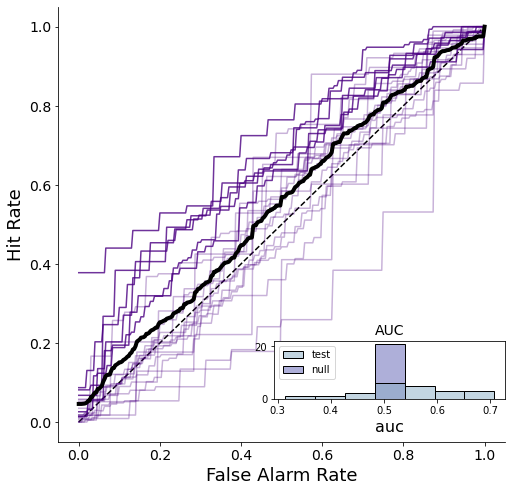

In [8]:
with open(f"clf_results_closed_loop.pkl", "rb") as f:
    cl_result_dict = pickle.load(f)
plt.rcParams['figure.facecolor']='white'
sns.set_palette('twilight')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
for subject in cl_result_dict:
    fp, tp, auc, _ = cl_result_dict[subject]
    tp = scp.interp(base_fp, fp, tp)
    tp_list.append(tp)
    if np.mean(cl_result_dict[subject][2] > cl_result_dict[subject][3])>=0.95:
        alpha=0.8
    else:
        alpha=0.3
    ax.plot(base_fp, tp, color='indigo', label=f"{subject}, AUC = {auc:.3f}", alpha=alpha)

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4,
        label=f"{subject}, AUC = {auc:.3f}", alpha=1)

# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18)
ax.set_xlabel('False Alarm Rate', fontsize=18)
plt.grid(False)
top_ax = fig.add_axes([0.5, .2, .4, .1])
auc_dist = pd.DataFrame({"auc":[cl_result_dict[k][2] for k in cl_result_dict] +
                         [np.mean(cl_result_dict[k][3]) for k in cl_result_dict],
                         "type":["test"]*len(cl_result_dict)+["null"]*len(cl_result_dict)})
sns.histplot(auc_dist, x="auc", hue="type", multiple="layer", bins=7, ax=top_ax)
top_ax.grid(False)
top_ax.set_title('AUC', fontsize=14)
top_ax.set_ylabel('')
sns.move_legend(top_ax, loc='upper left', title='')
# top_ax.axvline(0.5, ls='--')
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# top_ax.tick_params(labelsize=14)
plt.savefig('FinalReport/cl_roc.pdf', dpi=200, bbox_inches='tight')

In [12]:
len(result_dict)

22

In [66]:
good_class_subs = [k for k in cl_result_dict if np.mean(cl_result_dict[k][3]>cl_result_dict[k][2])<.05]
good_class_mask = np.isin(list(cl_result_dict.keys()), good_class_subs)
good_class_subs
avg['good_class'] = good_class_mask

In [29]:
np.isin(list(cl_result_dict.keys()), good_class_subs)

array([ True, False,  True, False, False, False,  True,  True, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False])

In [7]:
len([k for k in cl_result_dict if np.mean(cl_result_dict[k][3]>cl_result_dict[k][2])<.05])

6

In [11]:
len([k for k in cl_result_dict if np.mean(result_dict[k][3]>result_dict[k][2])<.05])

16

In [10]:
len(cl_result_dict)

21

## Compare AUC for RO and CL

In [33]:
auc_frame = pd.DataFrame({'Record-Only':[result_dict[k][2] for k in cl_result_dict], 
              'Closed-Loop':[cl_result_dict[k][2] for k in cl_result_dict]})
auc_frame_melt = pd.melt(auc_frame, var_name='type', value_name='auc')

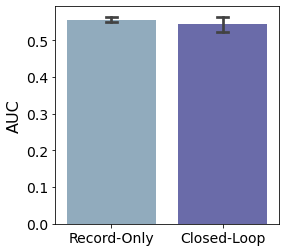

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.barplot(data=auc_frame_melt,
            x='type',y='auc', orient='vertical', ci=68, capsize=.1)
# ax.set_ylim(0.5)
ax.tick_params(labelsize=14)
ax.set_xlabel('')
ax.set_ylabel('AUC')
ax.grid(False)
plt.savefig('FinalReport/cl_ro_AUC_comparison.png', dpi=200, bbox_inches='tight')

In [35]:
scp.stats.ttest_rel(auc_frame['Record-Only'], auc_frame['Closed-Loop'])

Ttest_relResult(statistic=0.6202041740574749, pvalue=0.5421263377940593)

In [70]:
auc_frame

,Record-Only,Closed-Loop
0,0.550459,0.656436
1,0.485519,0.483852
2,0.575867,0.601562
3,0.522095,0.471555
4,0.541850,0.586807
5,0.589504,0.391741
6,0.585922,0.663475
7,0.619852,0.636016
8,0.508076,0.546335
9,0.611040,0.575720


## Classifier Weights

In [1]:
def compute_activation(X, weights):
    '''A = cov(X) * W / cov(y_hat)'''
    # where X = train_data.values
    
    activations = np.cov(X.T).dot(weights) / np.cov(X.dot(weights))

    # activations shape: N features array
    return activations

In [50]:
path = '/scratch/nicls_intermediate/read_only/encoding_powers/'
all_feats = []
all_activation = []
for sub in cl_result_dict:
    if sub not in good_class_subs:
        continue
#     powers, events = load_powers(sub)
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = ts.indexes['event'].to_frame(index=False)
    ts = ts.groupby('session').reduce(scp.stats.zscore, dim='event', ddof=1)
    powers = ts.data
    classif = ClassifierModel(LogisticRegression(), sklearn_version).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{sub}/nicls_{sub}_classifier.json")
    all_feats.append(classif.model_params['coef_'])
    activation = compute_activation(powers, classif.model.coef_.flatten())
    all_activation.append(activation)
all_feats = np.vstack(all_feats)
all_activation = np.vstack(all_activation)
                                    